# Best model configuration.

### Libraries and functions

In [2]:
import warnings
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, make_scorer,classification_report,confusion_matrix

def classificator_score(clasificador, entrenamiento,y_test):
    print('Best parameters:\n')
    best_parameters = clasificador.best_estimator_.get_params()
    for param in sorted(best_parameters.keys()):
        print((param, best_parameters[param]))
    prediction = clasificador.predict(entrenamiento)
    matew = matthews_corrcoef(y_test, prediction)
    print('Matthews correlation coefficienr:', matew)
    #print("Confusion Matrix: \n ", confusion_matrix(y_test, prediction))
    return prediction

def preporcessing_data(type_analyzer,ngram_size,feature_chosed):
    postables_local = open("../../dataset/TablesPOS.txt").readlines()
    possentenes_local = open("../../dataset/NoTablesPOS.txt").readlines()
    poscomplete_local = postables_local + possentenes_local

    if feature_chosed != ['all']:
        new_sentence = []
        for sentence_num in range(len(poscomplete_local)):
            tokens = poscomplete_local[sentence_num].split(' ')
            new_words = []
            for word_num in tokens:
                if word_num in feature_chosed:
                    new_words.append(word_num)
            new_sentence.append(' '.join(new_words))
    else:
        new_sentence = poscomplete_local


    class_label_local = []
    for i in range(len(new_sentence)):
        if i < len(postables_local):
            class_label_local.append('TABLES')
        else:
            class_label_local.append('NONE TABLES')

    fun_x_train, fun_x_test, fun_y_train, fun_y_test = train_test_split(new_sentence, class_label_local, train_size=0.85, test_size=0.15)

    tdifvectorizer = TfidfVectorizer(analyzer = type_analyzer,ngram_range=ngram_size)
    x_train_fun = tdifvectorizer.fit_transform(fun_x_train)
    x_test_fun = tdifvectorizer.transform(fun_x_test)

    variance_selector = VarianceThreshold()
    variance_selector = variance_selector.fit(x_train_fun,x_test_fun)
    x_train_fun = variance_selector.transform(x_train_fun)
    x_test_fun = variance_selector.transform(x_test_fun)

    return  x_train_fun, x_test_fun, fun_y_train, fun_y_test


def run_classifier_grid(x_train, x_test, y_train, y_test ,scorer_fun):
    f1scores = []
    mathewscores = []
    print("\n----------------------------------- Random Forest -----------------------------------------")
    rand_forest_classifier = RandomForestClassifier()
    rand_forest_param_grid = {'n_estimators': [100, 150, 200, 300],
                              'bootstrap': [True, False],
                              'criterion': ["gini", "entropy"],
                              'class_weight': ['balanced', None]}

    random_forest = model_selection.RandomizedSearchCV(rand_forest_classifier, rand_forest_param_grid, cv=crossV,
                                                       n_jobs=jobs, scoring=scorer_fun, verbose=0)
    random_forest.fit(x_train, y_train)
    rand_forest_predict = classificator_score(random_forest, x_test, y_test)
    score = f1_score(y_test, rand_forest_predict, pos_label='TABLES', average='binary')
    matw = matthews_corrcoef(y_test, rand_forest_predict)
    f1scores.append(score)
    mathewscores.append(matw)
    print(classification_report(y_test, rand_forest_predict))

    print("\n----------------------------------- SGDClassifier  -----------------------------------------")
    sgdc_classifier = SGDClassifier(loss='log')
    sgdc_param_grid = {'alpha': [10 ** (-x) for x in range(7)],
                       'penalty': ['elasticnet', 'l1', 'l2'],
                       'l1_ratio': [0.15, 0.25, 0.5, 0.75],
                       'class_weight': ['balanced', None], }

    sgdc_model = model_selection.RandomizedSearchCV(sgdc_classifier, sgdc_param_grid, cv=crossV, n_iter=50, n_jobs=jobs,
                                                    scoring=scorer_fun, verbose=0)
    sgdc_model.fit(x_train, y_train)
    sgdc_predict = classificator_score(sgdc_model, x_test, y_test)
    score = f1_score(y_test, sgdc_predict, pos_label='TABLES', average='binary')
    matw = matthews_corrcoef(y_test, sgdc_predict)
    f1scores.append(score)
    mathewscores.append(matw)
    print(classification_report(y_test, sgdc_predict))

    print("\n-------------------- Radial Basis Function Support Vector Machine  --------------------")
    svm = SVC()
    svm_param_grid = {'C': np.arange(1, 50, 0.5),
                      'gamma': np.arange(0.01, 1.01, 0.1),
                      'kernel': ['rbf'], 'class_weight': ['balanced', None], }

    # The number of iterations was reduced in this example in order to save computational time,
    svm_rbf = model_selection.RandomizedSearchCV(svm, svm_param_grid, n_iter=100, cv=crossV, n_jobs=-1,
                                                 scoring=scorer_fun, verbose=0)
    svm_rbf.fit(x_train, y_train)
    svm_predict = classificator_score(svm_rbf, x_test, y_test)
    score = f1_score(y_test, svm_predict, pos_label='TABLES', average='binary')
    matw = matthews_corrcoef(y_test, svm_predict)
    f1scores.append(score)
    mathewscores.append(matw)
    print(classification_report(y_test, svm_predict))
    return f1scores, mathewscores


### Training with the best parameter configuration obtained during grid search.
#### Here we foucus on hyperparameter tuning.


In [3]:

run = 0
jobs = -1
crossV = 5
all_matew = {}
all_scores = {}

vectorization = ['char']
feature_selection =  ['None']
type_scorer = ['weighted']
n_gram_range = {'char':[(2,5),(3,5)]}
feature_type = {'all_pos':['all']}


for analyzer in vectorization:
    for ngram in n_gram_range[analyzer]:
        for scorer in type_scorer:

            if scorer == 'weighted':
                run_scorer = make_scorer(f1_score, average='weighted')
            else:
                run_scorer = make_scorer(f1_score, labels=['NONE TABLES','TABLES'],
                                         average = 'binary',pos_label = 'TABLES')

            for feature in feature_type.keys():
                which_features = feature_type[feature]
                x_train_ds, x_test_ds, y_train_labels, y_test_labels = preporcessing_data(analyzer,ngram,which_features)

                for selection in feature_selection:
                    run += 1
                    if (selection != 'None') and (feature == 'all_pos'):
                        selector = SelectPercentile(chi2,percentile=selection)
                        x_train_ds = selector.fit_transform(x_train_ds,y_train_labels)
                        x_test_ds = selector.transform(x_test_ds)


                    score_f1,score_mathew = run_classifier_grid(x_train_ds, x_test_ds, y_train_labels, y_test_labels, run_scorer)
                    print(f'Run #{run}')
                    print(f'F1 Score: {score_f1}')
                    print(f'Matthews Correlation: {score_mathew}')
                    print('Vectorization: ',analyzer,'\nN-gram range: ',ngram,'\nScorer: ',scorer,'\nSelected features',feature,'\nFeature selection',selection,'\nOversampling: None')
                    print('########################################################\n\n')
                    all_scores[f'Run{run}_f1'] = score_f1
                    all_matew[f'Run{run}_Matthew'] = score_mathew



# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(10, 7), layout='constrained',)
ax.plot(all_scores.keys(),all_scores.values(), label=['Random Forest','SGD Classifier','SVM'],linewidth=3)  # Plot some data on the axes.
ax.set_ylabel('F1-Score Positive Class',fontsize=13)  # Add a y-label to the axes.
ax.set_title("Scores using word n-grams size (1-3)",fontsize=15)  # Add a title to the axes.
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
ax.legend(fontsize=13)  # Add a legend.
plt.savefig('f1score')
plt.show()
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots(figsize=(10, 7), layout='constrained',)
ax.plot(all_matew.keys(),all_matew.values(), label=['Random Forest','SGD Classifier','SVM'],linewidth=3)  # Plot some data on the axes.
ax.set_ylabel('Matthews correlation coefficient',fontsize=13)  # Add a y-label to the axes.
ax.set_title("Scores using word n-grams size (1-3)",fontsize=15)  # Add a title to the axes.
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
ax.legend(fontsize=13)
plt.savefig('mathew')
plt.show()# Add a legend.


----------------------------------- Random Forest -----------------------------------------
Best parameters:

('bootstrap', False)
('ccp_alpha', 0.0)
('class_weight', 'balanced')
('criterion', 'gini')
('max_depth', None)
('max_features', 'auto')
('max_leaf_nodes', None)
('max_samples', None)
('min_impurity_decrease', 0.0)
('min_samples_leaf', 1)
('min_samples_split', 2)
('min_weight_fraction_leaf', 0.0)
('n_estimators', 100)
('n_jobs', None)
('oob_score', False)
('random_state', None)
('verbose', 0)
('warm_start', False)
Matthews correlation coefficienr: 0.8610203001091269
              precision    recall  f1-score   support

 NONE TABLES       1.00      1.00      1.00      6811
      TABLES       0.96      0.77      0.86        62

    accuracy                           1.00      6873
   macro avg       0.98      0.89      0.93      6873
weighted avg       1.00      1.00      1.00      6873


----------------------------------- SGDClassifier  ----------------------------------------

# Best Features
#### Top 30 most important features on our dataset. Features were generated by character-ngrams of size (2,3).

In [ ]:

postables = open("../../dataset/TablesPOS.txt").readlines()
possentenes = open("../../dataset/NoTablesPOS.txt").readlines()
poscomplete = postables + possentenes

class_label = []
len_instances = []
for i in range(len(poscomplete)):
    if i < len(postables):
        class_label.append('TABLES')
        len_instances.append(len(poscomplete[i].replace('\n','').split(' ')))
    else:
        class_label.append('NONE TABLES')
        len_instances.append(len(poscomplete[i].replace('\n','').split(' ')))

x_train, x_test, y_train, y_test = train_test_split(poscomplete, class_label, train_size=0.80, test_size=0.20)

vectorizer = TfidfVectorizer(analyzer = 'char',ngram_range=(2,5))
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

selector = SelectPercentile(chi2,percentile=1)
x_train = selector.fit_transform(x_train,y_train)
x_test = selector.transform(x_test)

rank = {}
length = []
words = []
all_features = vectorizer.get_feature_names()
best_features = list(selector.get_support(indices=True))
for i,top in enumerate(best_features):
    rank[f'#{i + 1}'] = ('(' + all_features[top] + ')')
    length.append(len(all_features[top]))
    size = [n for n in all_features[top].split(' ')]
    if size[0] == '' and size[-1] == '':
        words.append(len(size)-2)
    elif size[0] == '' or size[-1] == '':
        words.append(len(size)-1)
    else:
        words.append(len(size))

best_df = pd.DataFrame.from_dict(rank.values())
best_df['n-gram size'] = length
best_df.columns = ['Feature','N-gram Size']
best_df.index = [n for n in range(1,30)]
best_df['Tags considered'] = words[:30]
best_df

,Feature,N-gram Size,Tags considered
1,( . n),4,2
2,( . nn),5,2
3,( : :),4,2
4,( : : ),5,2
5,( cd c),5,2
6,( cd d),5,2
7,( cd s),5,2
8,( nn :),5,2
9,( nn d),5,2
10,( s),2,1


# Metrics and model performance


#############################################################################################################

Vectorizing...
Done!
#############################################################################################################
Training Classifier...
Done!


#############################################################################################################

Classifier Scores:

Precision (f1 Score):
Negative Class: % 0.9990453110082985 
Positve Class: % 0.8992248062015504

Confusion Matrix: 
  [[6802    7]
 [   6   58]] 


              precision    recall  f1-score   support

  NONE TABLE       1.00      1.00      1.00      6809
       TABLE       0.89      0.91      0.90        64

    accuracy                           1.00      6873
   macro avg       0.95      0.95      0.95      6873
weighted avg       1.00      1.00      1.00      6873



Aditional Info:
Number of suport Vectors for each class:  [386 210]



----------------------------------- Random Fore

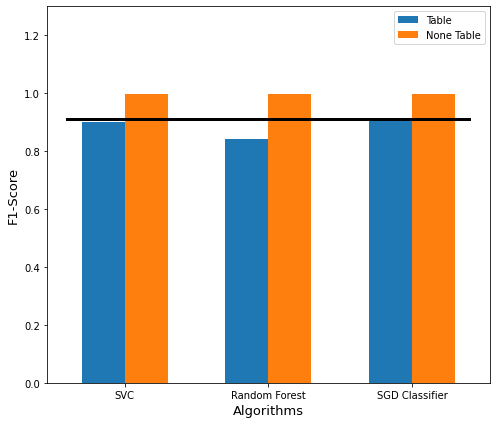

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

#############################################################################################################


    # VECTORIZATION AND DATA PREPROCESSING

## Directory and files to save trained model
### Storage directory of all required objects


## Extract POS of cases files. Uncoment if the input files are the ones returned by CoreNLP preprocessing.
#POS_extraction()


## Vectorize features
print("\n#############################################################################################################")
print('\nVectorizing...')

all_matew = {}
all_scores = {}
postables = open("../../dataset/TablesPOS.txt").readlines()
possentenes = open("../../dataset/NoTablesPOS.txt").readlines()
whole_text = postables + possentenes
f1scores = []
mathewscores = []

## Asign a positive or negative value.
class_label = []
for x in range(len(whole_text)):
    if x < len(postables):
        class_label.append('TABLE')
    else:
        class_label.append('NONE TABLE')

print('Done!')


## Split data for train and test the model
print("#############################################################################################################")
print("Training Classifier...")
X_train, X_test, y_train, y_test = train_test_split(whole_text, class_label, train_size=0.85, test_size=0.15,random_state=11)

# Vectorization
vectorizer = TfidfVectorizer(analyzer= 'char', ngram_range=(2,5))
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)
#joblib.dump(vectorizer, filename_vec)


## Deletion of reapeted columns.
variance_filtter = VarianceThreshold()
variance_filtter.fit(X_train, y_train)
#joblib.dump(variance_filtter, filename_variance)
X_train = variance_filtter.transform(X_train)
X_test = variance_filtter.transform(X_test)


#############################################################################################################


    # TRAINING SVM CLASSIFIER

ClassifierSVM =  SVC(C = 23.0, gamma= 0.41, shrinking=True, kernel='rbf', class_weight=None, probability=False)
ClassifierSVM.fit(X_train, y_train)
#joblib.dump(ClassifierSVM, filename_svm)
print('Done!')


# Classification scores and metrics.
print("\n\n#############################################################################################################")
print("\nClassifier Scores:\n")
print("Precision (f1 Score):")
svm_predict = ClassifierSVM.predict(X_test)
class_score = f1_score(y_test, svm_predict, average=None)
print("Negative Class: %", class_score[0], "\nPositve Class: %", class_score[1])
print("\nConfusion Matrix: \n ",confusion_matrix(y_test, svm_predict),'\n\n')
print(classification_report(y_test, svm_predict))
print('\n\nAditional Info:')
print('Number of suport Vectors for each class: ', ClassifierSVM.n_support_)
score = f1_score(y_test, svm_predict, pos_label='TABLE', average='binary')
matw = f1_score(y_test, svm_predict, pos_label='NONE TABLE', average='binary')
f1scores.append(score)
mathewscores.append(matw)

print("\n\n\n----------------------------------- Random Forest -----------------------------------------")


ClassifierRF =  RandomForestClassifier(bootstrap=False,n_estimators=100,criterion='gini',class_weight='balanced')
ClassifierRF.fit(X_train, y_train)
#joblib.dump(ClassifierSVM, filename_svm)
print('Done!\n')


# Classification scores and metrics.
print("#############################################################################################################")
print("Classifier Scores:\n")
print("Precision (f1 Score):")
rf_predict = ClassifierRF.predict(X_test)
class_score = f1_score(y_test, rf_predict, average=None)
print("Negative Class: %", class_score[0], "\nPositve Class: %", class_score[1])
print("\nConfusion Matrix: \n ",confusion_matrix(y_test, rf_predict),'\n\n')
print(classification_report(y_test, rf_predict))
score = f1_score(y_test, rf_predict, pos_label='TABLE', average='binary')
matw =  f1_score(y_test, svm_predict, pos_label='NONE TABLE', average='binary')
f1scores.append(score)
mathewscores.append(matw)


print("\n\n\n----------------------------------- SGDClassifier  -----------------------------------------")

ClassifierSGDC =  SGDClassifier(alpha=1e-06,class_weight=None,epsilon=0.1,l1_ratio=0.15,loss='log',penalty='l1')
ClassifierSGDC.fit(X_train, y_train)
#joblib.dump(ClassifierSVM, filename_svm)
print('Done!\n')


# Classification scores and metrics.
print("\n\n#############################################################################################################")
print("\nClassifier Scores:\n")
print("Precision (f1 Score):")
sgdc_predict = ClassifierSGDC.predict(X_test)
class_score = f1_score(y_test, sgdc_predict, average=None)
print("Negative Class: %", class_score[0], "\nPositve Class: %", class_score[1])
print("\nConfusion Matrix: \n ",confusion_matrix(y_test, sgdc_predict),'\n\n')
print(classification_report(y_test, sgdc_predict))
score = f1_score(y_test, sgdc_predict, pos_label='TABLE', average='binary')
matw =  f1_score(y_test, svm_predict, pos_label='NONE TABLE', average='binary')
f1scores.append(score)
mathewscores.append(matw)



all_scores['BestRun'] = f1scores
all_matew[f'BestRun'] = mathewscores

import numpy as np
import matplotlib.pyplot as plt

X = ['SVC','Random Forest','SGD Classifier']
values = list(all_scores.values())[0]
values3 = list(all_matew.values())[0]


X_axis = np.arange(len(X))
fig, ax = plt.subplots(figsize=(7, 6), layout='tight')
ax.bar(X_axis - 0.15, values, 0.3, label = 'Table')
ax.bar(X_axis + 0.15, values3, 0.3, label = 'None Table')
ax.set_xticks(X_axis, X)
ax.set_xlabel("Algorithms",fontsize=13)
ax.set_ylabel("F1-Score",fontsize=13)
ax.set_ylim(0,1.3)
plt.plot([-0.4,1,2.4],[0.91,0.91,0.91], linestyle='-',c='black',linewidth=3)
ax.legend()
plt.show()


# Binarize the targets
y_ = label_binarize(y_train, classes=['TABLES', 'NONE TABLE'])
y_test_ = label_binarize(y_test, classes=['TABLES', 'NONE TABLE'])

y_score = ClassifierSVM.decision_function(X_test)

## Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, threshold = roc_curve(y_test_, y_score)
roc_auc = auc(tpr,fpr)


fig, ax = plt.subplots( layout='constrained')
ax.plot(tpr,fpr, label = f'AUC = {round(roc_auc,2)}')
ax.legend(loc = 'lower right')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()
fig.savefig('../../AUC_ROC.png')


    # Precision-Recall Curve

average_precision = average_precision_score(y_test_, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
disp = plot_precision_recall_curve(ClassifierSVM, X_test, y_test)

plt.show()
plt.savefig('../../AUC-PR.png')

fig, ax = plt.subplots(figsize=(5, 4), layout='tight')
matrix = plot_confusion_matrix(ClassifierSVM, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.show()
plt.savefig('../../ConfusionMatrix.png')
